In [169]:
import mne
from mne.decoding import Scaler, Vectorizer, CSP, cross_val_multiscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
from scipy import io, stats

In [170]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.base import BaseEstimator, TransformerMixin

In [171]:
subject = '02'              # subject id to determine file path

tmin, tmax = -5.0, 20.0     # epoch start/end relative to event marker (seconds)
baseline = (None, -2.0)     # baseline correction  
sfreq = 200                 # sampling frequency of dataset

montage = mne.channels.make_standard_montage("standard_1005")   # international 10-5 system

ch_names = ['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG']   # all data channels

ch_types = ['eeg']*30 + ['eog']*2   # first 30 are EEG channels and other 2 are EOG channels

In [172]:
epochs = mne.read_epochs(f"epochs/subject_{subject}_epo.fif", preload=True)

Reading e:\Research Intern\cognitive-workload-assessment\epochs\subject_02_epo.fif ...
    Found the data of interest:
        t =   -5000.00 ...   20000.00 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


In [173]:
epochs.pick(picks=["eeg"], exclude='bads')

Number of events,60
Events,cond1: 30cond2: 30
Time range,-5.000 – 20.000 s
Baseline,-5.000 – -2.000 s


In [174]:
# X = pd.DataFrame(extracted_data)
X = epochs.get_data(copy=True)
y = epochs.events[:, -1]

In [175]:
class Feature_Extractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        Reshapes epoch data (assumed to be a 3D array with shape
        (n_epochs, n_channels, n_timepoints)) into a 2D matrix
        (n_epochs, n_channels * features).
        """
        curve_fitting_slopes = []

        for epoch in X:
            _slopes = []
            for channel in epoch:
                slope, _, _, _, _ = stats.linregress(range(0, len(channel)), channel)
                _slopes.append(slope)
            curve_fitting_slopes.append(_slopes)

        X_transformed = np.concatenate((
            np.mean(X, axis=-1),
            np.amax(X, axis=-1),
            curve_fitting_slopes,
            stats.skew(X, axis=-1),
            stats.kurtosis(X, axis=-1)
        ), axis=-1)  
        
        return X_transformed 

In [176]:
from skrebate import ReliefF

class ReliefF_Selector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.reliefF = ReliefF(n_neighbors=10)
        pass

    def fit(self, X, y=None):
        self.reliefF.fit(X, y)
        return self

    def transform(self, X, y=None):
        return X[:, self.reliefF.top_features_[:65]]

In [177]:
from mrmr import mrmr_classif

class MRMR_Selector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        data = pd.DataFrame(X, copy=True)
        labels = pd.Series(y, copy=True)

        self.selected_features = mrmr_classif(X=data, y=labels, K=20, show_progress=False)
        
        return self

    def transform(self, X, y=None):
        return X[:, self.selected_features]

In [178]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# X = scaler.fit_transform(X)

# from sklearn.feature_selection import chi2 

# chi2_selector = SelectKBest(chi2, k=20) 

# X = chi2_selector.fit_transform(X, y) 

In [179]:
from sklearn.feature_selection import f_classif

class ANOVA_Selector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.anova_selector = SelectKBest(f_classif, k=20) 
        self.anova_selector.fit(X, y)

        return self

    def transform(self, X, y=None):
        return self.anova_selector.transform(X)

In [180]:
# p_values = []

# for feature in X:
#     _, p_value = stats.kruskal(X[feature], y)
#     p_values.append(p_value)

# sorted_features = np.argsort(p_values)

# X = X.iloc[:, sorted_features[:20]]

In [181]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

In [183]:
w_length = int(sfreq * 3)
w_step = int(sfreq * 1)
w_start = np.arange(0, X.shape[2] - w_length, w_step)

In [184]:
def evaluate_classifiers(name, clf):
    scores_windows = []

    pipeline = make_pipeline(
        Scaler(epochs.info),
        Feature_Extractor(),
        ReliefF_Selector(),
        # MRMR_Selector(),
        # ANOVA_Selector(),
        clf
    )
    
    for i in w_start:
        scores = cross_val_score(pipeline, X[:, :, i : (i + w_length)], y, cv=5, scoring='roc_auc', verbose=False)
        scores_windows.append(scores)

    print(f"\n**************** {name} *************")
    print(f"1. Max score: {np.max(np.mean(scores_windows, 1), 0)}")
    print(f"2. Min score: {np.min(np.mean(scores_windows, 1), 0)}")
    print(f"3. Average score: {np.mean(np.mean(scores_windows, 1), 0)}")

    # Plot scores over time
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin
    
    plt.figure()
    plt.plot(w_times, np.mean(scores_windows, 1), label="Score")
    plt.axvline(0, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Chance")
    plt.xlabel("time (s)")
    plt.ylabel("classification accuracy")
    plt.title(f"Classification score over time: {name}")
    plt.legend(loc="lower right")
    plt.show()



**************** Logistic Regression *************
1. Max score: 0.7222222222222222
2. Min score: 0.23888888888888887
3. Average score: 0.4601449275362318


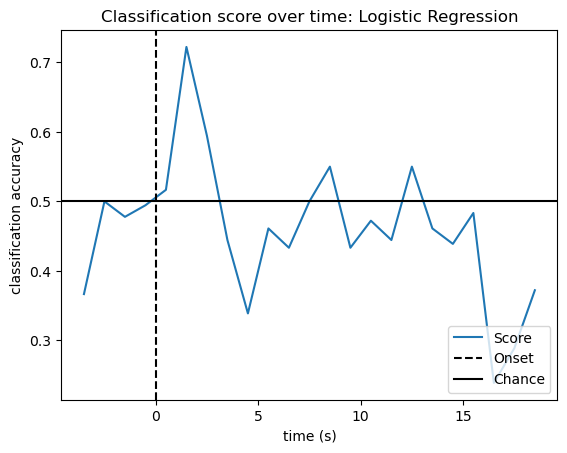


**************** LDA *************
1. Max score: 0.6555555555555557
2. Min score: 0.3055555555555556
3. Average score: 0.48260869565217396


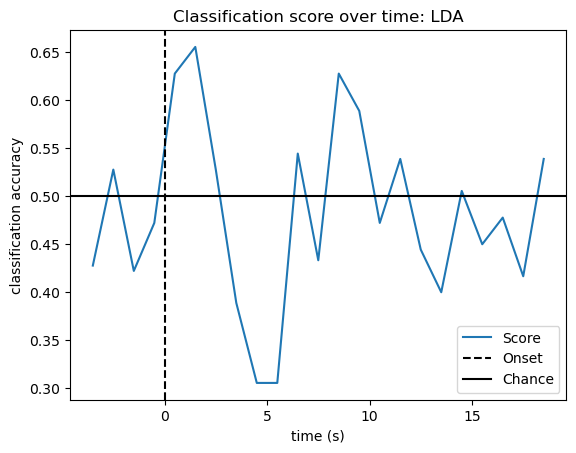


**************** SVM *************
1. Max score: 0.638888888888889
2. Min score: 0.2611111111111111
3. Average score: 0.4553140096618357


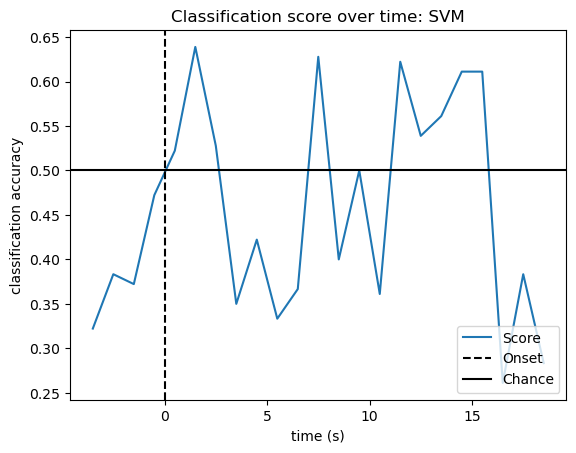


**************** Random Forest *************
1. Max score: 0.6194444444444445
2. Min score: 0.275
3. Average score: 0.478743961352657


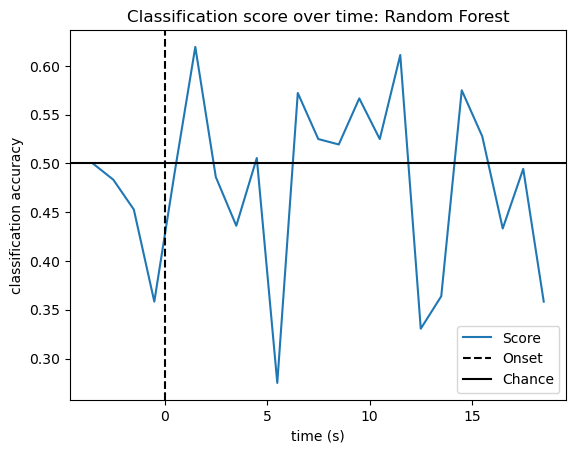

In [185]:
for name, clf in classifiers.items():
    evaluate_classifiers(name, clf)